In [9]:
import numpy as np
import pyvibdmc.simulation_utilities as util
import pyvibdmc as dmc
from pyvibdmc import potential_manager as pm
import matplotlib.pyplot as plt
import sys,os

In [15]:
pot_dir = '/'
py_file = 'h2o_potential.py'
pot_func = 'water_pot'

water_pot = pm.Potential(potential_function=pot_func,
                      python_file=py_file,
                      potential_directory=pot_dir,
                      num_cores=2)

In [113]:
eq_coord = np.array([[1.81005599,  0.        ,  0.        ],
                       [-0.45344658,  1.75233806,  0.        ],
                       [ 0.        ,  0.        ,  0.        ]])
cds = np.tile(eq_coord, (1001, 1, 1))
d_r = np.linspace(-1, 1, num=1001)
padded_d_r = np.zeros(cds.shape)
padded_d_r[:,0,0] = d_r
cds += padded_d_r

In [120]:
def V_mat(V, cds):
    return np.diag(V(cds))

def T_mat(x_grid):
    d_x = x_grid[1] - x_grid[0]
    dim = len(x_grid)
    c = 1/(2*d_x**2*MU)
    T_matrix = c*np.fromfunction(np.vectorize(T_generator), (dim, dim))
    return T_matrix

def T_generator(i,j):
    c = (-1)**(i-j)
    return c*np.pi**2/3 if i==j else c*2/(i-j)**2

def DVR(V, cds):
    a = np.min(cds[:,0,0])
    b = np.max(cds[:,0,0])
    x_grid= cds[:,0,0]
    V_matrix = V_mat(V, cds)
    T_matrix = T_mat(x_grid)
    E,evecs = np.linalg.eigh(V_matrix+T_matrix)
    
    return E, evecs, x_grid

In [129]:
MU = util.Constants.reduced_mass('O-H', to_AU=True)

def V_MO(x):
    return water_pot.getpot(x)

In [130]:
E_n, evecs, x_grid = DVR(V_MO, cds)

In [131]:
print(E_n[:10])

[0.00878383 0.02576807 0.04201848 0.05755561 0.07249947 0.08741048
 0.10334412 0.12100567 0.14048159 0.16164507]


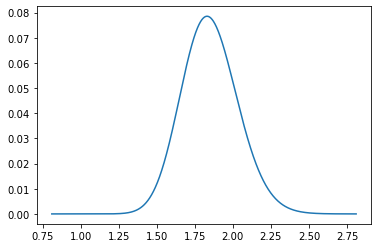

In [132]:
plt.plot(x_grid, evecs[:,0])

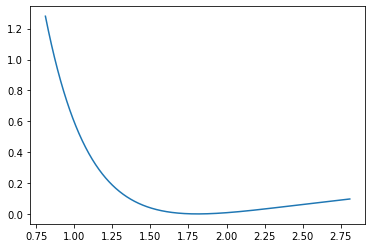

In [133]:
plt.plot(cds[:,0,0], water_pot.getpot(cds))